In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from urllib.parse import urlparse
from S01_dataset_preprocessing_pipeline import all_dataset
import torch.nn.functional as F
import torch.optim as optim
import random
import math
from trainer_class import Trainer
tqdm.pandas()
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"✅ Seed fixed to {seed}")

✅ Seed fixed to 42


In [2]:
# ============================================================
# Character Encoding Setup
# ============================================================

# Allowed printable ASCII chars
ascii_chars = [chr(i) for i in range(32, 127)]

# Special control tokens
special_tokens = [
    '<PAD>', '<UNK>',
]

# Build vocab and mapping
vocab = special_tokens + ascii_chars
char2idx = {ch: i for i, ch in enumerate(vocab)}



def encode(text, max_len=60):
    indices = torch.full((max_len,), char2idx["<PAD>"], dtype=torch.long)
    text = text.lower()[:max_len]
    for i, c in enumerate(text):
        indices[i] = char2idx.get(c, char2idx["<UNK>"])

    return indices





encoded_data = {}
frac = 1
gen = all_dataset()

x=0

max_len=128
#next(gen)
#next(gen)
#next(gen)
for name, splits in  gen:
    encoded_data[name] = {}
    print(f"\nEncoding structured URLs for {name}...")

    for split_name, df in zip(['train', 'valid', 'test'], splits):
        df = df.sample(frac=frac, random_state=42)
        df["encode"] = df["url"].progress_apply(lambda url: encode(url, max_len=max_len))
        encoded_data[name][split_name] = df
        print(f"{split_name}: Encoded {len(df)} URLs")


    #if x == 1:
    #    next(gen)
    x+=1


print("\nAll datasets encoded with proper start/end markers and padding!")


Encoding structured URLs for Dataset 1 (Malicious URLs)...


100%|██████████| 417732/417732 [01:21<00:00, 5156.83it/s]


train: Encoded 417732 URLs


100%|██████████| 52217/52217 [00:10<00:00, 5157.25it/s]


valid: Encoded 52217 URLs


100%|██████████| 52217/52217 [00:10<00:00, 5106.19it/s]


test: Encoded 52217 URLs

Encoding structured URLs for Dataset 2 (ndarvind/phiusiil-phishing)...


100%|██████████| 188296/188296 [00:24<00:00, 7785.30it/s]


train: Encoded 188296 URLs


100%|██████████| 23537/23537 [00:03<00:00, 7397.80it/s]


valid: Encoded 23537 URLs


100%|██████████| 23537/23537 [00:02<00:00, 7967.21it/s]


test: Encoded 23537 URLs

Encoding structured URLs for Dataset 3 (kmack/Phishing_urls)...


100%|██████████| 528097/528097 [01:29<00:00, 5915.41it/s]


train: Encoded 528097 URLs


100%|██████████| 66013/66013 [00:11<00:00, 5881.70it/s]


valid: Encoded 66013 URLs


100%|██████████| 66012/66012 [00:11<00:00, 5922.94it/s]


test: Encoded 66012 URLs

Encoding structured URLs for Dataset 4 (kaggels/taruntiwarihp/phishing-site-urls)...


100%|██████████| 405756/405756 [01:13<00:00, 5544.54it/s]


train: Encoded 405756 URLs


100%|██████████| 50720/50720 [00:09<00:00, 5539.05it/s]


valid: Encoded 50720 URLs


100%|██████████| 50719/50719 [00:09<00:00, 5304.18it/s]

test: Encoded 50719 URLs

All datasets encoded with proper start/end markers and padding!


In [3]:
# ============================================================
# Convert to TensorDataset and DataLoader
# ============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1024

dataloader_dict = {}

def make_tensor_dataset(df):
    url_tensor = torch.stack(list(df["encode"]))
    labels_tensor = torch.tensor(df["label"].astype(np.float32).values, dtype=torch.long)
    return TensorDataset(url_tensor, labels_tensor)

for name, splits in encoded_data.items():
    dataloader_dict[name] = {}
    print(f"\n📦 Creating DataLoaders for {name}...")
    
    train_set = make_tensor_dataset(splits["train"])
    val_set = make_tensor_dataset(splits["valid"])
    test_set = make_tensor_dataset(splits["test"])
    
    dataloader_dict[name]["train_loader"] = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    dataloader_dict[name]["val_loader"] = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    dataloader_dict[name]["test_loader"] = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    
    print(f"DataLoaders ready for {name} (Train/Val/Test)")

print("\nAll DataLoaders are ready in `dataloader_dict`!")

# Example Access:
# dataloader_dict["dataset1"]["train_loader"]



📦 Creating DataLoaders for Dataset 1 (Malicious URLs)...
DataLoaders ready for Dataset 1 (Malicious URLs) (Train/Val/Test)

📦 Creating DataLoaders for Dataset 2 (ndarvind/phiusiil-phishing)...
DataLoaders ready for Dataset 2 (ndarvind/phiusiil-phishing) (Train/Val/Test)

📦 Creating DataLoaders for Dataset 3 (kmack/Phishing_urls)...
DataLoaders ready for Dataset 3 (kmack/Phishing_urls) (Train/Val/Test)

📦 Creating DataLoaders for Dataset 4 (kaggels/taruntiwarihp/phishing-site-urls)...
DataLoaders ready for Dataset 4 (kaggels/taruntiwarihp/phishing-site-urls) (Train/Val/Test)

All DataLoaders are ready in `dataloader_dict`!


In [4]:
# =====================================================
# 🔹  Embeding_layer
# =====================================================
class Embeding_layer(nn.Module):
    def __init__(self,
                 vocab_size=256,
                 d_model=128,
                 max_len=100,
                 n_out=128,):
        super().__init__()

        # Byte embedding layer (0–255)
        self.embedding = nn.Embedding(vocab_size, d_model)

        # Positional embeddings
        #self.pos_embedding = nn.Embedding(max_len, d_model)
        # Final normalization
        
        self.projection = nn.Linear(in_features=d_model, out_features=n_out)
        self.norm = nn.LayerNorm(n_out)
        self.activation = nn.GELU()

    def forward(self, x):
        """
        x: (batch, seq_len) — byte indices [0–255]
        """
        #positions = torch.arange(seq_len, device=device).unsqueeze(0).expand(batch_size, -1)
        x = self.embedding(x) #+ self.pos_embedding(positions)

        x = self.projection(x)
        x = self.norm(x)
        x = self.activation(x)

        return x  # (B, L, d_model)

In [5]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (B, C, L)
        w = x.mean(dim=2)                          # Global Average Pooling -> (B, C)
        w = F.elu(self.fc1(w))
        w = self.sigmoid(self.fc2(w))
        w = w.unsqueeze(2)                         # (B, C, 1)
        return x * w                               # scale features

In [6]:
# 🔹 Residual Depthwise-Separable Multi-Kernel Block
class ResidualConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_sizes=[3],stride=1, dilations=[1], reduction=16, num_groups=32):
        super().__init__()

        #mid_ch = max(in_ch // 16, 8)  # reduce dimension before heavy convs
        self.branches = nn.ModuleList()

        for k in kernel_sizes:
            if k <= 5:
                for d in dilations:
                    branch = nn.Sequential(
                        # (B) Reduce channels first
                        #nn.Conv1d(in_ch, 1, kernel_size=1, bias=False),
                        
                        #nn.GroupNorm(num_groups=8, num_channels=mid_ch),
                        #nn.GELU(),
                        #nn.Dropout1d(0.25),

                        # (A) Depthwise conv
                        nn.Conv1d(in_ch, out_ch, kernel_size=k, padding=(k*d-1) // 2, bias=False, stride=stride, dilation=d),


                        # Pointwise to expand to out_ch
                        #nn.Conv1d(mid_ch, out_ch, kernel_size=1, bias=False),
                        #nn.GroupNorm(num_groups=8, num_channels=out_ch),
                        #nn.GELU()
                    )
                    self.branches.append(branch)
        
        for k in kernel_sizes:
            if k > 5:
                branch = nn.Sequential(
                        nn.Conv1d(in_ch, out_ch, kernel_size=k, padding=(k) // 2, bias=False, stride=stride, dilation=1),
                    )
                self.branches.append(branch)
        
        # Combine all kernel branches
        self.merge_conv = nn.Conv1d(out_ch * (len(self.branches)), out_ch, kernel_size=1, bias=False)
        #self.merge_bn = nn.BatchNorm1d(out_ch)
        #self.se = SEBlock(out_ch, reduction)
        self.shortcut = nn.Conv1d(in_ch, out_ch, kernel_size=1, stride=stride) if (in_ch != out_ch or stride!=1) else nn.Identity()
        self.group_norm = nn.GroupNorm(num_groups=num_groups, num_channels=out_ch)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout1d(0.25)

    def forward(self, x):
        # Parallel multi-kernel branches
        out = [branch(x) for branch in self.branches]
        out = torch.cat(out, dim=1)

        out = self.merge_conv(out)
        
        #out = self.se(out)
        out += self.shortcut(x)
        out = self.group_norm(out)
        out = self.gelu(out)
        out = self.dropout(out)
        return F.relu(out)

    


In [7]:
import torch.nn.functional as F

class DualAttentionPooling(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()

        # Temporal attention (softmax over T)
        self.temporal_attn = nn.Linear(channels, 1)

        # Channel attention (SE-style)
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        # x: (B, T, C)

        # ---- Temporal attention ----
        t_scores = self.temporal_attn(x)            # (B, T, 1)
        t_weights = torch.softmax(t_scores, dim=1)
        x = x * t_weights                           # (B, T, C)

        # ---- Channel attention ----
        c_context = x.mean(dim=1)                   # (B, C)
        c_weights = torch.sigmoid(
            self.fc2(F.gelu(self.fc1(c_context)))
        )                                           # (B, C)

        x = x * c_weights.unsqueeze(1)              # (B, T, C)

        # ---- Pool ----
        return x.sum(dim=1)                         # (B, C)


In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: [B, T, d_model]
        return x + self.pe[:, :max_len]

In [9]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model=64, n_heads=4, ff_dim=256, num_layers=2, dropout=0.1):
        super().__init__()

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True,
            activation="gelu"
        )

        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x, mask=None):
        return self.encoder(x, src_key_padding_mask=mask)


In [10]:
class AttentionPooling(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.attn = nn.Linear(dim, 1)

    def forward(self, x):
        # x: (B, T, C)
        weights = torch.softmax(self.attn(x), dim=1)
        return (weights * x).sum(dim=1)


In [114]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import json
class URLBinaryCNN_bestmodel(nn.Module):
    def __init__(self, maxlen=max_len, vocab_size = len(vocab),d_model=128, embed_dim=64):
        super().__init__()
        # Shared Layer (Global)
        self.shared_layer = nn.ModuleDict({
            "embeding":  Embeding_layer(vocab_size=vocab_size, max_len=maxlen, d_model=d_model, n_out=embed_dim),
            "conv": ResidualConvBlock(embed_dim, 64, kernel_sizes=[3,5,7], num_groups=8),
            #"conv2": ResidualConvBlock(64, 32, kernel_sizes=[3,5,7], num_groups=8),
            #"conv3": ResidualConvBlockDW(64, 32, kernel_sizes=[3,5,7]),
            #"conv4": ResidualConvBlockDW(128, 64, kernel_sizes=[3,5,7]),
            #"conv5": ResidualConvBlockDW(64, 32, kernel_sizes=[3,5,7]),

            #"proj": nn.Linear(64, 128),
            #"pos_enc": PositionalEncoding(d_model=64, max_len=maxlen),
            #"transformer": TransformerBlock(d_model=64, n_heads=4, ff_dim=256, num_layers=1),

            
            
            
        })

        # Personalization Layer (Local)
        self.personal_layer = nn.ModuleDict({
            "bilstm": nn.LSTM(input_size=64, hidden_size=64,num_layers=1, batch_first=True, bidirectional=True),
            "layer_norm": nn.LayerNorm(64*2),
            "gelu1": nn.GELU(),
            #"postconv": nn.Conv1d(64, 32, kernel_size=3),
            #"maxpool": nn.MaxPool1d(2),
            #"avg_pool1": nn.AvgPool1d(kernel_size=2),
            "attentionpooling": DualAttentionPooling(128),
            "fc1": nn.Linear(128 , 64),
            "layer_normalization1": nn.LayerNorm(64),
            "gelu2": nn.GELU(),
            "dropout1": nn.Dropout(0.25),
            "fc2": nn.Linear(64, 48),
            "gelu3": nn.GELU(),
            #"dropout2": nn.Dropout(0.25),
            "head": nn.Linear(48, 1)
        })

    def forward(self, x):
        # Shared layers
        x = self.shared_layer["embeding"](x)
        x = x.permute(0, 2, 1)

        x = self.shared_layer["conv"](x)
        #x = self.shared_layer["conv2"](x)
        #x = self.shared_layer["conv3"](x)
        #x = self.shared_layer["max_pool"](x)
        x = x.permute(0, 2, 1)
        
        #x = self.shared_layer["proj"](x)          # [B, T, 64]
        #x = self.shared_layer["pos_enc"](x)
        #x = self.shared_layer["transformer"](x)
        x, _ = self.personal_layer["bilstm"](x)
        x = self.personal_layer["layer_norm"](x)
        x = self.personal_layer["gelu1"](x)
        #x = x.permute(0, 2, 1)
        #x = self.shared_layer["postconv"](x)
        #x = self.shared_layer["maxpool"](x)
        #x = self.shared_layer["avg_pool1"](x)
        #x = x.permute(0, 2, 1)
        #x = x[:, -1, :]
        #x = x.flatten(1)
        x = self.personal_layer["attentionpooling"](x)
        x = self.personal_layer["dropout1"](self.personal_layer["gelu2"](self.personal_layer["layer_normalization1"](self.personal_layer["fc1"](x))))
        # Personalization head
        x = self.personal_layer["gelu3"](self.personal_layer["fc2"](x)) #self.personal_layer["dropout2"](
        x = self.personal_layer["head"](x)
        return x


In [12]:
vocab_size=len(vocab)
embed_dim=64


In [13]:
run_name = "best model till now testing"
changes={}

In [14]:
from plot_graph import plot_run
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# 🔧 Training Config
# ============================================================
num_epochs = [15,0,0]
lr_g = 0.001
lr_p = 0.001

# Store all dataset metrics
all_results = {}

# ============================================================
# 🔁 Training Loop for Each Dataset
# ============================================================ 

nn_model = {}
save=1
for dataset_name, loaders in dataloader_dict.items():
    print("\n" + "="*70)
    print(f"🚀 Training model on {dataset_name.upper()} dataset")
    print("="*70)
    for frac in  [1]:
        print(f"🧩 Using {frac*100:.0f}% of training data".center(50, '_'))
        train_loader = loaders["train_loader"]
        val_loader = loaders["val_loader"]
        nn_model[dataset_name] = URLBinaryCNN_bestmodel(vocab_size=len(vocab), embed_dim=64).to(device)
        global_params = []
        personal_params = []
        for name, param in nn_model[dataset_name].shared_layer.named_parameters():
            global_params.append(param)
        for name, param in nn_model[dataset_name].personal_layer.named_parameters():
            personal_params.append(param)
        criterion = nn.BCEWithLogitsLoss() #nn.BCELoss() #
        personal_optimizer = torch.optim.AdamW(personal_params, lr=lr_p, weight_decay=2e-4)
        global_optimizer = torch.optim.AdamW(global_params, lr=lr_g, weight_decay=1e-4)
        personal_scheduler = optim.lr_scheduler.ReduceLROnPlateau(personal_optimizer, mode='min', factor=0.5, patience=1, min_lr=1e-6)
        global_scheduler = optim.lr_scheduler.ReduceLROnPlateau(global_optimizer, mode='min', factor=0.5, patience=1, min_lr=1e-6)
        run_name = f"best model till now testing_{dataset_name}"
        trainer = Trainer(nn_model[dataset_name], criterion,run_name=run_name+str(frac if frac!=1 else ''),dataset_name=dataset_name,changes=changes, train_loader=train_loader, val_loader=val_loader, personal_optimizer=personal_optimizer, global_optimizer=global_optimizer, scheduler_g=global_scheduler, scheduler_p=personal_scheduler, save=save)
        # Lists to track performance
        trainer.train(num_epochs,frac=frac,val_frac=frac, log=2)
        th = trainer.tune_threshold(to_tune='f1')
        trainer.test(loaders['test_loader'], th)
        if save:plot_run(trainer.run_folder)

    '''
    # Store all results for this dataset
    all_results[dataset_name] = {
        "batch_train_losses": trainer.batch_train_losses,
        "batch_train_accs": trainer.batch_train_accs,
        "epoch_train_losses":  ,
        "epoch_train_accs": trainer.epoch_train_accs,
        "epoch_val_losses": trainer.epoch_val_losses,
        "epoch_val_accs": trainer.epoch_val_accs,
        "batch_times": trainer.batch_time,
        "epoch_times": trainer.epoch_time
    }
    '''
print("\n All datasets trained successfully!")

# ============================================================
# Summary of All Results
# ============================================================
print("\n" + "="*70)
print("Final Validation Accuracy Summary")
print("="*70)
for name, res in all_results.items():
    print(f"{name:<20} | Val Acc: {res["epoch_val_losses"][-1]:.4f} | Val Loss: {res["epoch_val_accs"][-1]:.4f}")



🚀 Training model on DATASET 1 (MALICIOUS URLS) dataset
__________🧩 Using 100% of training data___________
Run folder created at: training_runs\2026-01-15_05-15-45_best model till now testing_Dataset 1 (Malicious URLs)


c:\Users\rrpra\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\fx\_symbolic_trace.py:923: UserWarning: Was not able to add assertion to guarantee correct input x to specialized function. It is up to the user to make sure that your inputs match the inputs you specialized the function with.
  warnings.warn(


Epoch 1/15: Training global+personal | Batch 400/409 | Loss: 0.1264, Acc: 0.9600 | Val Loss: 0.1062, Val Acc: 0.9655
 Best Loss Model Saved! Val Loss = 0.1062 | Weights captured  epoch 1
Epoch 2/15: Training global+personal | Batch 400/409 | Loss: 0.1016, Acc: 0.9707 | Val Loss: 0.0899, Val Acc: 0.9699
 Best Loss Model Saved! Val Loss = 0.0899 | Weights captured  epoch 2
Epoch 3/15: Training global+personal | Batch 400/409 | Loss: 0.0890, Acc: 0.9678 | Val Loss: 0.0789, Val Acc: 0.9732
 Best Loss Model Saved! Val Loss = 0.0789 | Weights captured  epoch 3
Epoch 4/15: Training global+personal | Batch 400/409 | Loss: 0.0673, Acc: 0.9746 | Val Loss: 0.0699, Val Acc: 0.9758
 Best Loss Model Saved! Val Loss = 0.0699 | Weights captured  epoch 4
Epoch 5/15: Training global+personal | Batch 400/409 | Loss: 0.0723, Acc: 0.9775 | Val Loss: 0.0677, Val Acc: 0.9770
 Best Loss Model Saved! Val Loss = 0.0677 | Weights captured  epoch 5
Epoch 6/15: Training global+personal | Batch 400/409 | Loss: 0.06

KeyboardInterrupt: 

In [ ]:
#cross dataset accuracy
print("train_datasets".ljust(50,' ')+"| test_datasets".ljust(150,' '))
print(' '*50, end='')
for test_datset_name in nn_model:
    print(f"| {test_datset_name}".ljust(50,' '), end='')
print()
print('='+(('='*49)+'|')*4)
for train_dataset_name in nn_model:
    print(f'{train_dataset_name}'.ljust(50,' '), end='')
    for test_dataset_name in nn_model.keys():
        train_loader = dataloader_dict[test_dataset_name]['train_loader']
        test_loader = dataloader_dict[test_dataset_name]['test_loader']
        trainer = Trainer(nn_model[train_dataset_name], criterion, train_loader=train_loader, val_loader=test_loader,save=0)
        avg_val_loss, val_acc = trainer.evaluate()   
        print(f"| {avg_val_loss:.4f},{val_acc:.4f}".ljust(50,' '), end='')
    print()


## fedrated learning with persnalization
# meta learing



In [148]:
list(dataloader_dict.keys())[-1]

'Dataset 4 (kaggels/taruntiwarihp/phishing-site-urls)'

In [149]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [150]:
#train global model on little part(5%) of dataset
dataset_name = 'Dataset 4 (kaggels/taruntiwarihp/phishing-site-urls)' #use first dataset as default
global_model = URLBinaryCNN_bestmodel(vocab_size=len(vocab), maxlen=128).to(device)
loaders = dataloader_dict[dataset_name]
train_loader = loaders["train_loader"]
val_loader = loaders["val_loader"]
lr_p=0.001
lr_g=0.001
frac = 0.1
print(f"🧩 Using {frac*100:.0f}% of training data".center(50, '_'))

global_params = []
persnalization_params = []
for name, param in global_model.shared_layer.named_parameters():
    global_params.append(param)
for name, param in global_model.personal_layer.named_parameters():
    persnalization_params.append(param)
criterion = nn.BCEWithLogitsLoss()
g_personal_optimizer = torch.optim.NAdam(persnalization_params, lr=lr_p, weight_decay=lr_p/10)
g_global_optimizer = torch.optim.NAdam(global_params, lr=lr_g, weight_decay=lr_g/10)
g_personal_scheduler = optim.lr_scheduler.ReduceLROnPlateau(g_personal_optimizer, mode='min', factor=0.5, patience=1)
g_global_scheduler = optim.lr_scheduler.ReduceLROnPlateau(g_global_optimizer, mode='min', factor=0.5, patience=1)

trainer = Trainer(global_model, criterion, train_loader=train_loader, val_loader=val_loader, personal_optimizer=g_personal_optimizer, global_optimizer=g_global_optimizer, scheduler_g=g_global_scheduler, scheduler_p=g_personal_scheduler,save=0)
        
# Lists to track performance
trainer.train(epochs_list=[0,0,0],frac=frac,val_frac=frac, log=2)



___________🧩 Using 10% of training data___________


In [151]:
import plotly.graph_objects as go

# Data from your 2 epochs
epochs = tuple(range(1,len(trainer.epoch_train_losses)+1))

train_loss = trainer.epoch_train_losses
val_loss   = trainer.epoch_val_losses

# -------- Train Loss vs Epoch --------
fig_train = go.Figure()
fig_train.add_trace(go.Scatter(
    x=epochs,
    y=train_loss,
    mode='lines+markers',
    name='Train Loss'
))

fig_train.update_layout(
    title='Train Loss vs Epoch',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    template='plotly_dark'
)

fig_train.show()


# -------- Validation Loss vs Epoch --------
fig_val = go.Figure()
fig_val.add_trace(go.Scatter(
    x=epochs,
    y=val_loss,
    mode='lines+markers',
    name='Validation Loss'
))

fig_val.update_layout(
    title='Validation Loss vs Epoch',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    template='plotly_dark'
)

fig_val.show()


In [152]:
import copy
def make_clients(train_dataset,val_dataset, dataset_name, num_clients=5, alpha=0.5, total_data=1, batch_size=256, max_train_samples_per_client=50000, max_val_samples_per_client=8000):
    import numpy as np
    # using alpha to produce unidentical splits high alpha more identical
    client_fractions = np.random.dirichlet([alpha] * num_clients) * total_data
    total_train_len = int(len(train_dataset) * total_data)
    total_val_len   = int(len(val_dataset) * total_data)
    train_start = 0
    val_start = 0
    client_models = []
    for i in range(num_clients):
        train_size = int(client_fractions[i] * total_train_len)
        val_size   = int(client_fractions[i] * total_val_len)

        train_size = min(train_size, max_train_samples_per_client)
        val_size   = min(val_size, max_val_samples_per_client)

        train_end = min(train_start + train_size, len(train_dataset))
        val_end   = min(val_start + val_size, len(val_dataset))

        train_slice = train_dataset.iloc[train_start:train_end]
        val_slice   = val_dataset.iloc[val_start:val_end]

        train_start = train_end
        val_start   = val_end

        client_model = URLBinaryCNN_bestmodel(vocab_size=len(vocab), maxlen=128).to(device)                     # fresh instance
        client_model.shared_layer.load_state_dict(global_model.shared_layer.state_dict())
        train_set = make_tensor_dataset(train_slice)
        val_set   = make_tensor_dataset(val_slice)
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
        client_models.append({'model':client_model, 'train_loader':train_loader,'val_loader':val_loader, 'val_acc':0, 'dataset':dataset_name})
    return client_models, client_fractions


def quick_fine_tune(model, train_loader, personal_optimizer,frac=1, epochs=1):

    criterion = nn.BCEWithLogitsLoss()

    # ▶▶ added save=0
    trainer = Trainer(
        model,
        criterion=criterion,
        train_loader=train_loader,
        personal_optimizer=personal_optimizer,
        save=0
    )

    trainer.train(epochs_list=[0,0,epochs], frac=frac, log=0)


def train_client(client_devices, epoch=1):
    print("training client models: ")
    client_acc = []
    client_losses = []
    for i, client_device in enumerate(client_devices):
        print('\tclient ',i,'dataset', client_device['dataset'][8], end=' ')
        criterion = nn.BCEWithLogitsLoss()
        lr_p = 0.001
        lr_g = 0.0005

        personal_optimizer = torch.optim.NAdam(client_device['model'].personal_layer.parameters(), lr=lr_p, weight_decay=lr_p/10)
        global_optimizer = torch.optim.NAdam(client_device['model'].shared_layer.parameters(), lr=lr_g, weight_decay=lr_g/10)

        personal_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            personal_optimizer, mode='min', factor=0.5, patience=1
        )
        global_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            global_optimizer, mode='min', factor=0.5, patience=1
        )

        # ▶▶ added save=0
        trainer = Trainer(
            client_device['model'],
            criterion=criterion,
            train_loader=client_device['train_loader'],
            val_loader=client_device['val_loader'],
            personal_optimizer=personal_optimizer,
            global_optimizer=global_optimizer,
            scheduler_g=global_scheduler,
            scheduler_p=personal_scheduler,
            save=0
        )

        trainer.train(epochs_list=[epoch,0,0],log=0)
        #print("epoch accuracies:-", trainer.epoch_val_accs)
        client_losses.append(trainer.epoch_val_losses)
        client_acc.append(trainer.epoch_val_accs)
    print()
    return client_losses, client_acc


def fed_meta_learing(global_model, client_devices, meta_lr=0.1, train_loader=train_loader, global_personal_optimizer=g_personal_optimizer, quick_tune_epoch = 2):
    total_samples = sum(len(client_device['train_loader'].dataset) for client_device in client_devices)
    trim_ratio = 0.2  # 10% trimming
    num_clients = len(client_devices)
    k = int(trim_ratio * num_clients)

    weights = [
        len(client_device['train_loader'].dataset) / total_samples
        for client_device in client_devices
    ]
    global_state = {
        **global_model.shared_layer.state_dict()
    }

    avg_state = copy.deepcopy(global_state)
    '''
    for key in avg_state.keys():

        # 1. Collect all client tensors for this parameter
        client_tensors = []
        for i, client_device in enumerate(client_devices):
            client_state = client_device['model'].shared_layer.state_dict()
            client_tensors.append(client_state[key])

        # Shape: [num_clients, *param_shape]
        stacked = torch.stack(client_tensors, dim=0)

        # 2. Sort across client dimension
        sorted_tensor, _ = torch.sort(stacked, dim=0)

        # 3. Trim extremes
        if k > 0:
            trimmed_tensor = sorted_tensor[k:-k]
        else:
            trimmed_tensor = sorted_tensor

        # 4. Mean of remaining values
        avg_state[key] = torch.mean(trimmed_tensor, dim=0)
    '''
    for key in avg_state.keys():
        avg_state[key] = torch.zeros_like(avg_state[key])
        for client_device, w in zip(client_devices, weights):
            client_state = {
                **client_device['model'].shared_layer.state_dict(),
            #**client_model.personal_layer.state_dict()
            }
            avg_state[key] += client_state[key] * w

    new_state = {}
    for key in global_state.keys():
        new_state[key] = global_state[key] + meta_lr * (avg_state[key] - global_state[key])


    global_model.shared_layer.load_state_dict({
        k: v for k, v in new_state.items() if k in global_model.shared_layer.state_dict()
    })
    quick_fine_tune(global_model,train_loader,global_personal_optimizer,  0.1, epochs=quick_tune_epoch)

def soft_update(client, global_model, alpha=0.3):
    for c_p, g_p in zip(client.shared_layer.parameters(), global_model.shared_layer.parameters()):
        c_p.data = c_p.data + alpha * (g_p.data - c_p.data)

def update_clients(client_devices, global_model, alpha=0.3, quick_tune_epoch = 3):
    #client_acc_avg = sum([client_device['val_acc'] for client_device in client_devices])/len(client_devices)
    #client_std = sum([(client_device['val_acc']-client_acc_avg)**2 for client_device in client_devices])/len(client_devices)**(1/2)
    for i, client_device in enumerate(client_devices):
        client_device['model'].shared_layer.load_state_dict(global_model.shared_layer.state_dict())
        soft_update(client=client_device['model'], global_model=global_model, alpha=alpha)

        personal_optimizer = torch.optim.NAdam(client_device['model'].personal_layer.parameters(), lr=0.001, weight_decay=lr_p/10)
        #client.personal_layer.load_state_dict(global_model.shared_layer.state_dict())
        quick_fine_tune(client_device['model'], client_device['train_loader'], personal_optimizer,epochs=quick_tune_epoch)
        pass
def evaluate_client(client_devices):
    avg_val_losses, val_accs = [], []
    for i, client_device in enumerate(client_devices):
        criterion = nn.BCEWithLogitsLoss()
        trainer = Trainer(client_device['model'], criterion=criterion, train_loader=client_device['train_loader'], val_loader=client_device['val_loader'],save=0)
        avg_val_loss, val_acc = trainer.evaluate()
        avg_val_losses.append(avg_val_loss)
        val_accs.append(val_acc)
        client_device['val_acc'] = val_acc
    return avg_val_losses, val_accs

In [155]:
client_devices, client_fractions = [], []
for Dataset_name in encoded_data:
    client_device, client_fraction = make_clients(num_clients=1, train_dataset=encoded_data[Dataset_name]['train'], val_dataset=encoded_data[Dataset_name]['valid'], dataset_name=Dataset_name, total_data=0.60,alpha=10, batch_size=256) 
    client_devices.extend(client_device)
    client_fractions.extend(client_fraction)
    print(Dataset_name)

print(client_fractions)
print('clints initial accuracy')
avg_val_losses, val_accs = evaluate_client(client_devices)
for i, (avg_val_loss, val_acc) in enumerate(zip(avg_val_losses,val_accs)):
    print(avg_val_loss, val_acc, client_fractions[i])

Dataset 1 (Malicious URLs)
Dataset 2 (ndarvind/phiusiil-phishing)
Dataset 3 (kmack/Phishing_urls)
Dataset 4 (kaggels/taruntiwarihp/phishing-site-urls)
[np.float64(0.5999999999999999), np.float64(0.6), np.float64(0.5999999999999999), np.float64(0.6)]
clints initial accuracy
0.8162345886230469 0.175375 0.5999999999999999
0.6905823335647583 0.425125 0.6
0.7169507360458374 0.495 0.5999999999999999
0.6584634866714477 0.774625 0.6


In [156]:
import os
import json
import datetime
import torch

class FLLogger:
    def __init__(self, base_dir="runs", run_name=None):
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        self.run_name =  f"{timestamp}_{run_name if run_name else ''}"
        self.run_dir = os.path.join(base_dir, self.run_name)

        os.makedirs(self.run_dir, exist_ok=True)
        os.makedirs(os.path.join(self.run_dir, "checkpoints"), exist_ok=True)

        self.global_metrics = {
            "loss": [],
            "accuracy": []
        }

        self.client_metrics = {}

    # ------------------------------
    def save_config(self, config: dict):
        with open(os.path.join(self.run_dir, "config.json"), "w") as f:
            json.dump(config, f, indent=4)

    # ------------------------------
    def log_global_muti(self, loss, acc):
        self.global_metrics["loss"].extend(loss)
        self.global_metrics["accuracy"].extend(acc)
    def log_global(self, loss, acc):
        self.global_metrics["loss"].append(float(loss))
        self.global_metrics["accuracy"].append(float(acc))

    # ------------------------------
    def log_client(self, client_id, loss, acc):
        if client_id not in self.client_metrics:
            self.client_metrics[client_id] = {
                "loss": [],
                "accuracy": []
            }
        self.client_metrics[client_id]["loss"].append(float(loss))
        self.client_metrics[client_id]["accuracy"].append(float(acc))

    # ------------------------------
    def save_checkpoint(self, model, epoch):
        path = os.path.join(
            self.run_dir, "checkpoints", f"global_epoch_{epoch}.pt"
        )
        torch.save(model.state_dict(), path)

    # ------------------------------
    def flush(self):
        with open(os.path.join(self.run_dir, "global_metrics.json"), "w") as f:
            json.dump(self.global_metrics, f, indent=4)

        with open(os.path.join(self.run_dir, "client_metrics.json"), "w") as f:
            json.dump(self.client_metrics, f, indent=4)

        summary = {
            "final_global_loss": self.global_metrics["loss"][-1],
            "final_global_accuracy": self.global_metrics["accuracy"][-1],
            "num_clients": len(self.client_metrics)
        }

        with open(os.path.join(self.run_dir, "summary.json"), "w") as f:
            json.dump(summary, f, indent=4)


In [157]:
trainer = Trainer(global_model, criterion, train_loader=train_loader, val_loader=val_loader,save=0)

global_epoch = 10
client_epoch = 1

logger = FLLogger(run_name="fed_trimed_avgv3")

logger.save_config({
    "global_epochs": global_epoch,
    "client_epochs": client_epoch,
    "num_clients": len(client_devices),
    "meta_lr": 0.2,
    "soft_alpha": 0.4,
    "client_quick_epochs": 3,
    "global_quick_epochs": 2,
    "optimizer": "NAdam",
    "loss": "BCELoss",
    "model": "URLBinaryCNN"
})


trainer = Trainer(global_model, criterion, train_loader=train_loader, val_loader=val_loader,save=0)
for i in range(global_epoch):
    print(f"global epoch '{i+1}' ", end="")
    losses, accuracies = train_client(client_devices, epoch=client_epoch)

    for cid, (loss_list, acc_list) in enumerate(zip(losses, accuracies)):
        for l, a in zip(loss_list, acc_list):
            logger.log_client(cid, l, a)
    loss, acc = trainer.evaluate(frac=0.1)
    logger.log_global(loss, acc)

    # ---- Server update
    fed_meta_learing(global_model, client_devices, meta_lr=0.8, quick_tune_epoch=1)

    # ---- Update clients
    update_clients(client_devices, global_model, alpha=0.7, quick_tune_epoch=1)

    # ---- Client evaluation
    losses, accuracies = evaluate_client(client_devices)
    for cid, (l, a) in enumerate(zip(losses, accuracies)):
        logger.log_client(cid, l, a)

    # ---- Global eval again
    loss, acc = trainer.evaluate(frac=0.1)
    logger.log_global(loss, acc)

    # ---- Save checkpoint
    logger.save_checkpoint(global_model, i)

    print(f"\tglobal model loss {loss:.4f} accuracy {acc:.4f}")
logger.flush()


global epoch '1' training client models: 
	client  0 dataset 1 	client  1 dataset 2 	client  2 dataset 3 	client  3 dataset 4 
	global model loss 0.4135 accuracy 0.8273
global epoch '2' training client models: 
	client  0 dataset 1 	client  1 dataset 2 	client  2 dataset 3 	client  3 dataset 4 
	global model loss 0.2900 accuracy 0.8869
global epoch '3' training client models: 
	client  0 dataset 1 	client  1 dataset 2 	client  2 dataset 3 	client  3 dataset 4 
	global model loss 0.2359 accuracy 0.9105
global epoch '4' training client models: 
	client  0 dataset 1 	client  1 dataset 2 	client  2 dataset 3 	client  3 dataset 4 
	global model loss 0.2339 accuracy 0.9097
global epoch '5' training client models: 
	client  0 dataset 1 	client  1 dataset 2 	client  2 dataset 3 	client  3 dataset 4 
	global model loss 0.1887 accuracy 0.9302
global epoch '6' training client models: 
	client  0 dataset 1 	client  1 dataset 2 	client  2 dataset 3 	client  3 dataset 4 
	global model loss 0.1701 ac

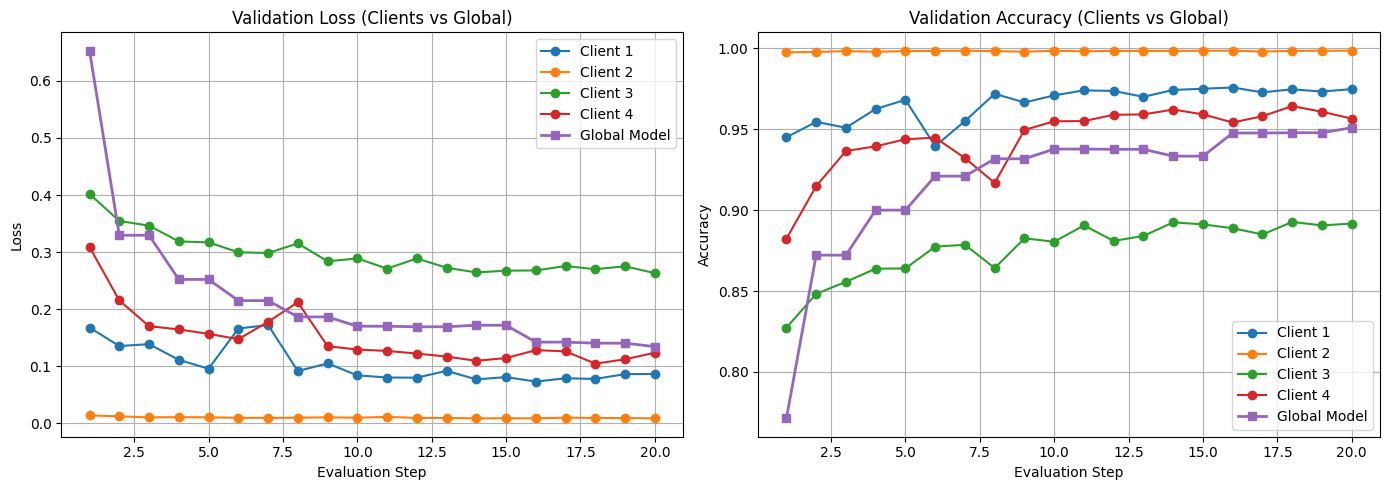

In [133]:
import matplotlib.pyplot as plt

# ------------------------------
# Prepare figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ------------------------------
# Subplot 1: Validation Loss
for client_id, metrics in logger.client_metrics.items():
    losses = metrics["loss"]
    epochs = list(range(1, len(losses) + 1))
    axes[0].plot(epochs, losses, marker='o', label=f"Client {client_id + 1}")

# Global loss
global_losses = logger.global_metrics["loss"]
global_epochs = list(range(1, len(global_losses) + 1))
axes[0].plot(global_epochs, global_losses, marker='s', linewidth=2, label="Global Model")

axes[0].set_title("Validation Loss (Clients vs Global)")
axes[0].set_xlabel("Evaluation Step")
axes[0].set_ylabel("Loss")
axes[0].grid(True)
axes[0].legend()

# ------------------------------
# Subplot 2: Validation Accuracy
for client_id, metrics in logger.client_metrics.items():
    accuracies = metrics["accuracy"]
    epochs = list(range(1, len(accuracies) + 1))
    axes[1].plot(epochs, accuracies, marker='o', label=f"Client {client_id + 1}")

# Global accuracy
global_accs = logger.global_metrics["accuracy"]
global_epochs = list(range(1, len(global_accs) + 1))
axes[1].plot(global_epochs, global_accs, marker='s', linewidth=2, label="Global Model")

axes[1].set_title("Validation Accuracy (Clients vs Global)")
axes[1].set_xlabel("Evaluation Step")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


In [134]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# -------------------------------------------------
# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=(
        "Validation Loss (Clients vs Global)",
        "Validation Accuracy (Clients vs Global)"
    )
)

# -------------------------------------------------
# Assign fixed colors per client
palette = px.colors.qualitative.Dark24  # journal-friendly
client_colors = {
    client_id: palette[client_id % len(palette)]
    for client_id in logger.client_metrics.keys()
}

# -------------------------------------------------
# Subplot 1: Validation Loss (Clients)
for client_id, metrics in logger.client_metrics.items():
    losses = metrics["loss"]
    steps = [x / (client_epoch + 1)
             for x in range(1, client_epoch * global_epoch + global_epoch + 1)]

    fig.add_trace(
        go.Scatter(
            x=steps,
            y=losses,
            mode="lines+markers",
            name=f"client{client_id + 1} {client_devices[client_id]['dataset'][:10]}",
            legendgroup=f"{client_devices[client_id]['dataset'][:10]}",
            line=dict(color=client_colors[client_id]),
            marker=dict(color=client_colors[client_id]),
            opacity=0.4
        ),
        row=1, col=1
    )

# Global model loss
global_losses = logger.global_metrics["loss"][::2]
global_steps = list(range(1, len(global_losses) + 1))

fig.add_trace(
    go.Scatter(
        x=global_steps,
        y=global_losses,
        mode="lines+markers",
        name="Global Model",
        legendgroup="global",
        line=dict(color="black", width=3),
        marker=dict(symbol="square", size=8, color="black")
    ),
    row=1, col=1
)

# -------------------------------------------------
# Subplot 2: Validation Accuracy (Clients)
for client_id, metrics in logger.client_metrics.items():
    accuracies = metrics["accuracy"]
    steps = [x / (client_epoch + 1)
             for x in range(1, client_epoch * global_epoch + global_epoch + 1)]

    fig.add_trace(
        go.Scatter(
            x=steps,
            y=accuracies,
            mode="lines+markers",
            name=f"client{client_id + 1} {client_devices[client_id]['dataset'][:10]}",
            legendgroup=f"{client_devices[client_id]['dataset'][:10]}",
            showlegend=False,  # legend only once (left plot)
            line=dict(color=client_colors[client_id]),
            marker=dict(color=client_colors[client_id]),
            opacity=0.4
        ),
        row=1, col=2
    )

# Global model accuracy
global_accs = logger.global_metrics["accuracy"][::2]
global_steps = list(range(1, len(global_accs) + 1))

fig.add_trace(
    go.Scatter(
        x=global_steps,
        y=global_accs,
        mode="lines+markers",
        name="Global Model",
        legendgroup="global",
        showlegend=False,
        line=dict(color="black", width=3),
        marker=dict(symbol="square", size=8, color="black")
    ),
    row=1, col=2
)

# -------------------------------------------------
# Axis labels
fig.update_xaxes(title_text="Evaluation Step", row=1, col=1)
fig.update_xaxes(title_text="Evaluation Step", row=1, col=2)
fig.update_yaxes(title_text="Loss", row=1, col=1)
fig.update_yaxes(title_text="Accuracy", row=1, col=2)

# -------------------------------------------------
# Vertical lines (Global Rounds)
for g in range(1, global_epoch + 1):
    fig.add_vline(
        x=g,
        line=dict(color="orange", dash="dash", width=1)
    )

# -------------------------------------------------
# Layout
fig.update_layout(
    height=520,
    width=1200,
    template="plotly_white",
    hovermode="x unified"
)

fig.show()
